In [ ]:
import tweepy
import pandas as pd

In [ ]:
results_wk3=pd.read_csv("results_wk3.csv")
results_wk12=pd.read_csv("results_wk1_and_2.csv")

Combine all weeks of data

In [59]:
results_wk123=pd.concat((results_wk3,results_wk12.iloc[:,3:18]), axis=0).reset_index()

In [64]:
results_wk123["text_no_punc_lower_no_dig"].isnull().sum()

1

In [65]:
results_wk123= results_wk123[results_wk123["text_no_punc_lower_no_dig"].notna()]

In [66]:
results_wk123.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82479 entries, 0 to 82479
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   level_0                       82479 non-null  int64  
 1   index                         82479 non-null  int64  
 2   text                          82479 non-null  object 
 3   edit_history_tweet_ids        82479 non-null  object 
 4   created_at                    82479 non-null  object 
 5   id                            82479 non-null  object 
 6   author_id                     82479 non-null  object 
 7   context_annotations           48503 non-null  object 
 8   public_metrics_retweet_count  82479 non-null  int64  
 9   public_metrics_reply_count    82479 non-null  int64  
 10  public_metrics_like_count     82479 non-null  int64  
 11  public_metrics_quote_count    25104 non-null  float64
 12  hashtag                       68950 non-null  object 
 13  t

In [200]:
results_wk123[['public_metrics_retweet_count','public_metrics_reply_count','public_metrics_like_count']].describe()
#not a super retweetable or liked topic, I guess? Or maybe it's hard for things to go viral on twitter in this space. At any rate, it's highlyg skewed

,public_metrics_retweet_count,public_metrics_reply_count,public_metrics_like_count
count,82479.000000,82479.000000,82479.000000
mean,2.253834,1.076407,7.662435
std,54.529841,33.383572,146.402882
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,2.000000
max,8167.000000,5382.000000,20650.000000


In [227]:
results_wk123.public_metrics_like_count.info()


<class 'pandas.core.series.Series'>
Int64Index: 82479 entries, 0 to 82479
Series name: public_metrics_like_count
Non-Null Count  Dtype  
--------------  -----  
82479 non-null  float32
dtypes: float32(1)
memory usage: 3.0 MB


TFID CountVectorizer

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [83]:

tfid_vec = TfidfVectorizer(stop_words='english',
                      use_idf=True, 
                      smooth_idf=True,
                      min_df=100,  # This is default; this is just a reminder it exists
                      max_df=0.8,
                      preprocessor=prep)

In [84]:
sum([len(d.split(' ')) for d in results_wk123.text_no_punc_lower_no_dig])

2796052

In [192]:
testingtfid=tfid_vec.fit_transform(results_wk123["text_no_punc_lower_no_dig"])

In [74]:
tfid_vec.get_feature_names()

/Users/sidan/opt/anaconda3/envs/classification/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['able',
 'access',
 'according',
 'account',
 'achieve',
 'act',
 'action',
 'actually',
 'add',
 'agenda',
 'agree',
 'agriculture',
 'air',
 'allow',
 'amazon',
 'america',
 'amp',
 'analysis',
 'annual',
 'app',
 'apple',
 'approach',
 'aren',
 'art',
 'article',
 'ask',
 'atmosphere',
 'auditing',
 'australia',
 'australian',
 'available',
 'average',
 'aviation',
 'away',
 'bad',
 'bank',
 'banks',
 'based',
 'batteries',
 'battery',
 'begins',
 'believe',
 'benefit',
 'benefits',
 'best',
 'better',
 'biden',
 'big',
 'bigger',
 'biggest',
 'billion',
 'bills',
 'bit',
 'bitcoin',
 'blockchain',
 'bring',
 'build',
 'building',
 'burning',
 'business',
 'businesses',
 'buy',
 'buying',
 'called',
 'canada',
 'canadian',
 'canadians',
 'cap',
 'capture',
 'car',
 'card',
 'care',
 'cars',
 'case',
 'cash',
 'cause',
 'cbdc',
 'chain',
 'change',
 'changes',
 'check',
 'china',
 'city',
 'claim',
 'claims',
 'class',
 'clean',
 'climate',
 'closed',
 'coal',
 'come',
 'comes',
 'c

In [73]:
testingtfid.shape

(26553, 646)

In [75]:
testingtfid.toarray

<bound method _cs_matrix.toarray of <26553x646 sparse matrix of type '<class 'numpy.float64'>'
	with 188406 stored elements in Compressed Sparse Row format>>

k-means

In [96]:
from sklearn.cluster import KMeans

In [97]:
from sklearn.metrics import silhouette_score

In [98]:
#https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html
seed=42
#%%time
# compare a broad range of ks to start
ks = [2, 50, 200, 500]


# track a couple of metrics
sil_scores = []
inertias = []

# fit the models, save the evaluation metrics from each run
for k in ks:
    #logging.warning('fitting model for {} clusters'.format(k))
    model = KMeans(n_clusters=k, random_state=seed)
    model.fit(testingtfid)
    labels = model.labels_
    sil_scores.append(silhouette_score(testingtfid, labels))
    inertias.append(model.inertia_)



NameError: name 'plt' is not defined

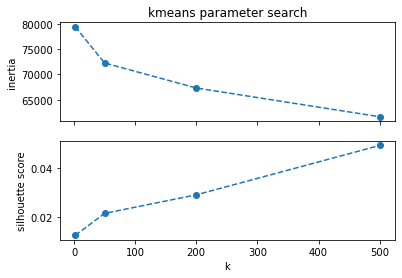

In [100]:
# plot the quality metrics for inspection
fig, ax = plt.subplots(2, 1, sharex=True)

plt.subplot(211)
plt.plot(ks, inertias, 'o--')
plt.ylabel('inertia')
plt.title('kmeans parameter search')

plt.subplot(212)
plt.plot(ks, sil_scores, 'o--')
plt.ylabel('silhouette score')
plt.xlabel('k');

In [101]:
#https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html

best_k = 200

km_model = KMeans(n_clusters=best_k, random_state=seed)
km_model.fit(testingtfid)

KMeans(n_clusters=200, random_state=42)

In [103]:
import numpy as np

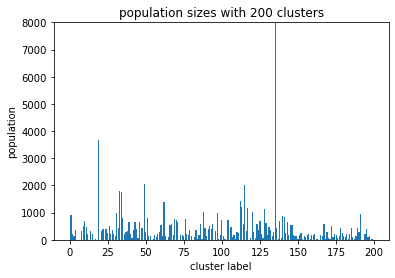

In [106]:
#https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html
plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(best_k));

# truncate y axis to see the rest better
# (comment out to see the peak value for the largest cluster)
plt.ylim(0,8000);

In [107]:
smaller_k = 20
km_model = KMeans(n_clusters=smaller_k,  random_state=seed)
km_model.fit(testingtfid)

KMeans(n_clusters=20, random_state=42)

In [108]:
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, 
    random_state=42, tol=0.0001, verbose=0)

KMeans(n_clusters=20, random_state=42)

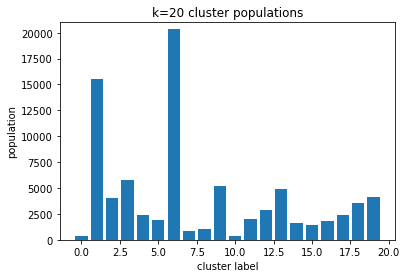

In [113]:
plt.bar(range(len(set(km_model.labels_))), np.bincount(km_model.labels_))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('k={} cluster populations'.format(smaller_k));

# truncating the axis again!
plt.ylim(0,21000);

In [114]:
#https://twitterdev.github.io/do_more_with_twitter_data/clustering-users.html
def strongest_features(model, vectorizer, topk=10):
    """
    Helper function to display a simple text representation of the top-k most
    important features in our fit model and vectorizer.

    model: sklearn model
    vectorizer: sklearn vectorizer
    topk: k numbers of words to get per cluster

    """
    # these parts are model-independent
    m_name = model.__class__.__name__
    features = vectorizer.get_feature_names()
    # different calculations per model type
    if m_name is 'KMeans':
        relevant_labels = list(set(model.labels_))
        centroids = model.cluster_centers_.argsort()[:,::-1]
        for this_label in relevant_labels:
            print('Cluster {}:'.format(this_label), end='')
            for ind in centroids[this_label, :topk]:
                print(' {}'.format(features[ind]), end='')
            print()
    elif m_name is 'HDBSCAN':
        # ignore noise labels
        relevant_labels = [ x for x in set(model.labels_) if x >= 0 ]
        for this_label in relevant_labels:
            matching_rows = np.where(hdbs.labels_ == this_label)[0]
            coeff_sums = np.sum(bio_matrix[matching_rows], axis=0).A1
            sorted_coeff_idxs = np.argsort(coeff_sums)[::-1]
            print('Cluster {}: '.format(this_label), end='')
            for idx in sorted_coeff_idxs[:topk]:
                print('{} '.format(features[idx]), end='')
            print()
    else:
        raise NotImplementedError('This helper method currently only supports KMeans and HDBSCAN models')

<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/s7/_b96xmkx3klbpc4y0sz29j0r0000gn/T/ipykernel_90435/3085646143.py:16: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if m_name is 'KMeans':
/var/folders/s7/_b96xmkx3klbpc4y0sz29j0r0000gn/T/ipykernel_90435/3085646143.py:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif m_name is 'HDBSCAN':


In [115]:
strongest_features(km_model, vec, topk=15)

Cluster 0: auditing reporting pledged includedsee value chain average plan yrs report achieve annual credits incomplete later
Cluster 1: carbon footprint market offset offsets just like reducing emissions people markets new world bank make
Cluster 2: energy zero net renewable carbon solar clean footprint world use emissions transition power crisis gas
Cluster 3: credits credit carbon tax social digital score market tesla money selling card just like buy
Cluster 4: green zero net energy carbon agenda neutral new footprint amp economy hydrogen guardian sceptic gas
Cluster 5: going zero carbon net footprint neutral just like people think world new need green make
Cluster 6: zero net emissions new world uk just people need global like read gas help reach
Cluster 7: impt check impactful token presale investing program hey join offset amp competition ecosystem carbon blockchain
Cluster 8: company million carbon footprint tons dioxide metric number known favorite eco environmentalists fellow 

/Users/sidan/opt/anaconda3/envs/classification/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Named Entity Recognition

In [151]:
!pip install spacy
import spacy
from spacy import displacy



In [231]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 4.7 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [154]:

nlp = spacy.load('en_core_web_sm')

In [152]:
from collections import Counter

In [155]:
#John TA helped me create this code, along with: https://towardsdatascience.com/from-dataframe-to-named-entities-4cfaa7251fc0
final_counter = Counter({}) #check if this is a way to initialize a counter
for i in range(len(results_wk123)//1000): #every time taking a sizable chunk and are getting overwritten each time instead of storing in memory (very common) - do minus 1 
     subset = results_wk123['text_no_punc_lower_no_dig'][i*1000:i*1000+1000]  #
     tokens= nlp(''.join(str(subset.tolist()))) #on the last looop, we may get values outside the range
     items = [x.text for x in tokens.ents]
     final_counter += Counter(items) #fancy dictionary lists each object and number of times that it appears

In [156]:
final_counter

Counter({"tipper 🖕'": 1,
         'one': 1739,
         'un': 627,
         'million tonnes': 94,
         'edtech': 2,
         'zero': 32405,
         "the year  '": 8,
         'every year': 42,
         'australia': 653,
         'cbdc smart wallet': 1,
         'a whole year  no': 1,
         'us': 397,
         'john kerry': 24,
         'today': 1491,
         'about two million': 72,
         'daily': 498,
         'egypt': 128,
         'holland': 12,
         'democrat': 34,
         "the end of the year '": 3,
         'many years': 24,
         'hong kong': 28,
         'first': 1736,
         'canadian': 245,
         "plandemie jako předehra   '": 1,
         'this year': 166,
         'china': 1504,
         'india': 785,
         'albania': 2,
         'trudeau': 32,
         'tofino': 1,
         'bbc': 66,
         'millions': 288,
         'twenty miles': 1,
         'florida': 26,
         'halloween': 45,
         'taylor swift’s': 3,
         'brian': 2,
         

In [157]:
#https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
{k: v for k, v in sorted(final_counter.items(), reverse=True, key=lambda item: item[1])}


{'zero': 32405,
 'uk': 1983,
 'one': 1739,
 'first': 1736,
 'china': 1504,
 'today': 1491,
 'boris': 921,
 'india': 785,
 'don': 683,
 'australia': 653,
 'years': 643,
 'un': 627,
 'eu': 583,
 'two': 551,
 'europe': 545,
 'decades': 503,
 'daily': 498,
 'canada': 477,
 'october': 474,
 'british': 433,
 'ukraine': 430,
 'us': 397,
 'russia': 375,
 'million metric tons': 374,
 'prince william': 357,
 'australian': 320,
 'billions': 318,
 'annual': 300,
 'million': 297,
 'millions': 288,
 'european': 259,
 'day two': 255,
 'canadian': 245,
 'paris': 239,
 'britain': 237,
 'qatar': 233,
 'tomorrow': 231,
 'johnson': 224,
 'london': 206,
 'germany': 206,
 'second': 202,
 'three': 200,
 '🌳': 200,
 'half': 198,
 'france': 188,
 'november': 179,
 'singapore': 178,
 'africa': 177,
 'putin': 174,
 'chinese': 172,
 'american': 171,
 'this year': 166,
 'this week': 166,
 '🤔': 164,
 'year': 162,
 'america': 157,
 'indian': 155,
 'california': 149,
 'saudi': 149,
 'every  years': 148,
 '🤣': 144,
 'h

In [260]:
items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('today', 38),
 ('zero', 33),
 ('one', 30),
 ('france', 26),
 ('saudi', 26),
 ('billions', 23),
 ('china', 22),
 ('million metric tons', 20),
 ('uk', 18),
 ('first', 17),
 ("saudi arabia '", 15),
 ("💚  '", 14),
 ('daily', 13),
 ('saudi arabia', 8),
 ('india', 8),
 ('million', 8),
 ('don', 8),
 ('un', 6),
 ('☢', 6),
 ('washington', 5)]

In [158]:
results_wk123.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82479 entries, 0 to 82479
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   level_0                       82479 non-null  int64  
 1   index                         82479 non-null  int64  
 2   text                          82479 non-null  object 
 3   edit_history_tweet_ids        82479 non-null  object 
 4   created_at                    82479 non-null  object 
 5   id                            82479 non-null  object 
 6   author_id                     82479 non-null  object 
 7   context_annotations           48503 non-null  object 
 8   public_metrics_retweet_count  82479 non-null  int64  
 9   public_metrics_reply_count    82479 non-null  int64  
 10  public_metrics_like_count     82479 non-null  int64  
 11  public_metrics_quote_count    25104 non-null  float64
 12  hashtag                       68950 non-null  object 
 13  t

Corex 

In [168]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt


In [169]:
#using metis Corex example

vec_corex = CountVectorizer(stop_words='english',
                      min_df=100,  # This is default; this is just a reminder it exists
                      max_df=0.8,
                      preprocessor=prep,
                      binary=True)

doc_word = vec_corex.fit_transform(results_wk123["text_no_punc_lower_no_dig"])
words = list(np.asarray(vec_corex.get_feature_names()))

/Users/sidan/opt/anaconda3/envs/classification/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [188]:
#from metis Corex example w/notes
# n_hidden is the number of topics
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=results_wk123["text_no_punc_lower_no_dig"])

In [189]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: zero,net,carbon,footprint,neutral,credits,offset,boris,market,immigration
1: company,million,palaces,chauffeured,castles,duke,helicopters,william,prince,cambridge
2: people,don,just,tax,like,money,stop,change,want,wef
3: report,achieve,discuss,learn,reporting,sustainability,transition,sustainable,register,auditing
4: energy,gas,solar,fossil,renewable,fuel,fuels,power,wind,electric
5: credit,social,digital,score,blockchain,currency,id,cbdc,usdc,card


In [191]:
topic_model.get_top_docs(topic=2, n_docs=20)

[(' the labour party say net zero by   so we will have uk people freezing to death to change   of global emissions while we buy foreign gas and stuff from china etc made from power produced from coal  business goes bust  jobs lost  virtue signalling on speed  mad ',
  0.0),
 ('   the   say net zero by   so we will have uk people freezing to death to change   of global emissions while we buy foreign gas and stuff from china etc made from power produced from coal  business goes bust  jobs lost  virtue signalling on speed  madness',
  0.0),
 ('lol… lots of people knew that changing from locally sourced coal to wood pellets was just ‘green virtue signalling’ but hey  that’s what greens get when their eco loon net zero climate crisis scam meets reality time and again  it’s just an elaborate way of fleecing the public  ',
  0.0),
 ('you slimy lot can do what you like the public hate a back stabber who got us into this mess in the first place  wef puppet whose wife made millions on our misery

In [ ]:
import matplotlib as plt

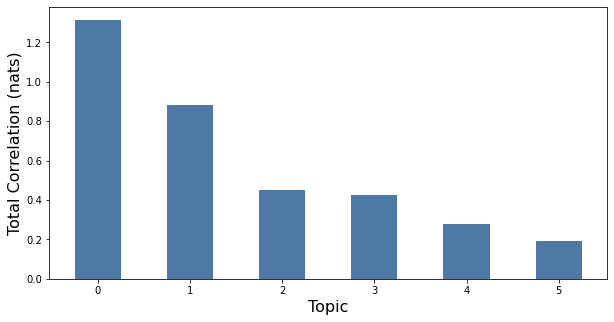

In [178]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [179]:
topic_model.tcs

array([1.31454295, 0.88206194, 0.45346108, 0.42384411, 0.27754013,
       0.19247768])

In [288]:
topic_model = ct.Corex(n_hidden=7, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=results_wk12_v2["text_no_punc_lower_no_dig"], 
                anchors=[['carbon', 'footprint', 'neutral','credit','offset','reduce','market'], 
                         ['boris', 'uk', 'immigration', 'labour'], 
                         ['renewable', 'energy', 'solar', 'fuel', 'electric','power','oil'], 
                         ], anchor_strength=2)



In [289]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))


0: carbon,footprint,zero,net,neutral,credit,offset,reduce,credits,market
1: boris,immigration,labour,illegal,party,wef,tory,brexit,lockdowns,conservative
2: energy,oil,power,fuel,solar,electric,renewable,fossil,gas,fuels
3: people,don,just,like,money,tax,make,need,doesn,think
4: emissions,new,sustainability,learn,read,projects,join,sustainable,goal,industry
5: company,million,tons,metric,auditing,dioxide,includedsee,favorite,reporting,number
6: climate,change,amp,global,action,transition,help,role,solutions,register


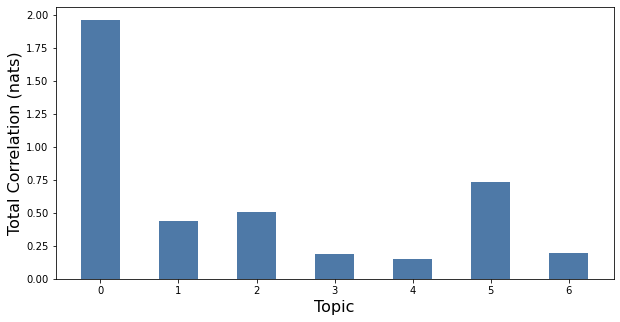

In [290]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [272]:
topics

[[('carbon', 1.6703075556183762, 1.0),
  ('footprint', 0.6086594960927958, 1.0),
  ('zero', 0.519795294011882, -1.0),
  ('net', 0.5046001863637047, -1.0),
  ('neutral', 0.15452849276858135, 1.0),
  ('credit', 0.050556270685894765, 1.0),
  ('offset', 0.048964303780247284, 1.0),
  ('reduce', 0.04591459075611644, 1.0),
  ('credits', 0.04201844895134205, 1.0),
  ('market', 0.03154078552221422, 1.0)],
 [('boris', 0.13040912396012247, 1.0),
  ('immigration', 0.11541753612998042, 1.0),
  ('labour', 0.06862854755070429, 1.0),
  ('illegal', 0.028445187541577883, 1.0),
  ('party', 0.02822150683093199, 1.0),
  ('wef', 0.02344027350365014, 1.0),
  ('tory', 0.021549124320017383, 1.0),
  ('brexit', 0.02140961120661765, 1.0),
  ('lockdowns', 0.01909774652361622, 1.0),
  ('conservative', 0.01810537692859509, 1.0)],
 [('energy', 0.43141977359658334, 1.0),
  ('oil', 0.12234293899702423, 1.0),
  ('power', 0.11964607918613206, 1.0),
  ('fuel', 0.0954545056659803, 1.0),
  ('solar', 0.08621989910094732, 1.0

In [291]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=results_wk12_v2["text_no_punc_lower_no_dig"], 
                anchors=[['carbon', 'footprint', 'neutral','credit','offset','reduce','market'], 
                         ['boris', 'uk', 'liz','sunak','johnson','truss','rishi'], 
                         ['renewable', 'energy', 'solar', 'fuel', 'electric','power','oil'], 
                         []
                         ], anchor_strength=2)



In [292]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))


0: carbon,footprint,zero,net,neutral,credit,offset,reduce,credits,market
1: uk,boris,immigration,johnson,sunak,truss,illegal,party,wef,rishi
2: energy,oil,power,fuel,solar,electric,renewable,fossil,gas,fuels
3: emissions,achieve,sustainability,report,join,learn,transition,amp,new,sustainable
4: people,don,just,like,tax,money,make,want,need,think
5: company,million,tons,dioxide,metric,number,favorite,known,thumbs,friendlies


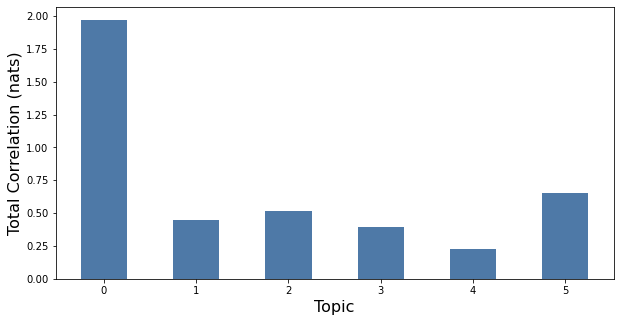

In [293]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);